## Preliminary Analysis of Dominik's 93 Colour Patch Comparison Data

2022-Jan-28  
Ariel Zeleznikow-Johnston

In [187]:
# hardcoded values
n.compare = 320
cor_threshold = 0.5
n.stim = 93

In [392]:
library(rgl)

In [371]:
library(tidyverse)
install.packages("ramify")
library(dplyr)
library(ggplot2)
install.packages("reshape2")
library(viridis)
library(MASS)
install.packages("hrbrthemes")
library(scales)
library(broom)
install.packages("pglm")
library(gtools)

package 'ramify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages
package 'reshape2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages
package 'hrbrthemes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages
package 'pglm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages


### Loading Data

In [3]:
# matching regex of any amount of characters then followed by .csv
files <- list.files(path="./data", pattern="*.csv", full.names=TRUE)
filesizes <- file.size(files)

# individual participant files use a unique ID to mark which colour pairs they saw
truthColourTableColumnNames <- c("r1", "g1", "b1", "r2", "g2", "b2")
truthColourTable <- read.csv("./colourcodes/colourcodes.csv", header=F)
names(truthColourTable) <- truthColourTableColumnNames

# not sure what the point of this is...?
files <- files[-(which(filesizes < 4))]

pilotdata <- sapply(files, read.csv, simplify=FALSE) %>% bind_rows(.id = "fileId")

In [4]:
# changing realcomparison from zero-indexed to one-indexed

participantsIDFrame <- data.frame(unique(pilotdata$participant))

pilotdata <- pilotdata %>% arrange("participant")

In [5]:
# variables of interest from collected data
trial_vars<- c( "participant", "practice_comparison", "pracsimilarity", "realcomparison", "similarity", "response_time", "trials_2.thisN") 
catch_vars<- c("participant", "catch_response_time", "catchnumberprac", "catchpracsimilarity", "catchnumber", "catchsimilarity", "catchRT", "catchtrialorder")
trialdata <- (pilotdata %>% filter(!is.na(realcomparison)))[trial_vars] # no catch trials
catchdata <- (pilotdata %>% filter(!is.na(catchnumber)))[catch_vars] # no main trials
trialdata = rename(trialdata, dissimilarity = similarity)

trialdata$realcomparison <- trialdata$realcomparison + 1 # fixing the indexing?

rgb2hex <- function(r, g, b) {rgb(r, g, b, maxColorValue = 255)}

In [27]:
# getting the colour pair comparison information

# compartmentalising the two dots presented to participants
firstColourSet <- truthColourTable[,truthColourTableColumnNames[1:3]]
secondColourSet <- truthColourTable[,truthColourTableColumnNames[4:6]]

names(firstColourSet) <- names(secondColourSet) <- c("r", "g", "b")

#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
                            
#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))

colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)


### Cleaning Data

##### Catch Trials

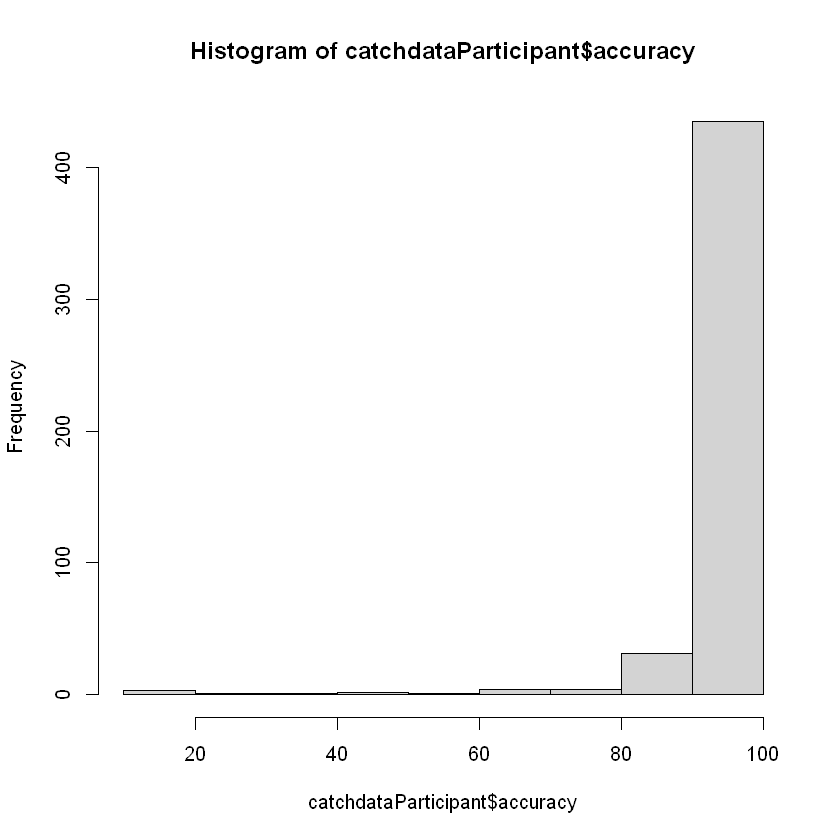

In [29]:
# catch trial scoring
#hist(catchdataParticipant$accuracy)


In [48]:
# assess whether participants passed
catch.assess <- function(catchdata){
    catchdata <- catchdata %>% mutate(is_valid_catch_response = if_else(catchnumber == catchsimilarity, 1, 0), is_invalid_catch_response = if_else(catchnumber != catchsimilarity, 1, 0))
    catchdataParticipant <- catchdata %>% group_by(participant) %>% 
      summarise(correct_responses=sum(is_valid_catch_response), incorrect_responses = sum(is_invalid_catch_response))

    catchdataParticipant$total <- catchdataParticipant$correct_responses + catchdataParticipant$incorrect_responses
    catchdataParticipant$accuracy <- (catchdataParticipant$correct_responses/catchdataParticipant$total) * 100
    return(catchdataParticipant)
}

# remove participants who scored below a certain threshold
catch.remove <- function(catchdata, trialdata, threshold){
    catch.participant <- catch.assess(catchdata)
    passed <- subset(catch.participant, accuracy >= threshold)$participant
    clean <- subset(trialdata, trialdata$participant %in% passed)
    return(clean)
}


In [50]:
# clean the trial data
clean.data <- catch.remove(catchdata,trialdata,80) # using 80% threshold

##### Within-subject double pass consistency

In [99]:
# each participant should have completed 320 trials
count.remove <- function(data, threshold){
    count <- data %>% count(participant)
    passed <- subset(count, n == threshold)$participant
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- count.remove(clean.data,n.compare)

##### Within-subject double pass consistency

In [118]:
double.pass.check <- function(data){
    v1 <- data$dissimilarity[1:(n.compare/2)]
    v2 <- data$dissimilarity[(n.compare/2+1):n.compare]
    return(cor(v1,v2))
}

pass.remove <- function(data, threshold=cor_threshold){
    IDs <- unique(data$participant)
    passed <- vector()
    for(id in IDs){
        tryCatch(
            {
                if(double.pass.check(subset(data, participant == id)) >= threshold){
                    passed <- c(passed,id)
                }
            },
            error=function(cond){
                message(paste("Something went wrong with correlations for participant:",id))
            }
        )
        
    }
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- pass.remove(clean.data)

Warning message in cor(v1, v2):
"the standard deviation is zero"
Something went wrong with correlations for participant: 60fdee1f5bb38a56c58631bc



### Descriptive plots & statistics

##### Matrix Visualisations

Setting up the matrix

In [127]:
# read in the colour comparison truth table
colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)

rowsTotalSetHEX <- rbind(data.frame(colour = firstColourSetHEX), data.frame(colour = secondColourSetHEX)) %>% group_by_all %>% count

# preliminary check that the data has been read in correctly
countOfUniqueRowsFirstSet <- length(unique(firstColourSetHEX))
countOfUniqueRowsSecondSet <- length(unique(secondColourSetHEX))
countOfUniqueRowsTotalSet <- length(rowsTotalSetHEX$colour)

In [163]:
# set lower triangle of matrix to NA - this gives heatmap its unique upper triangle
upperTriangularMatrix <- upper.tri(matrix(1, ncol = countOfUniqueRowsTotalSet, nrow = countOfUniqueRowsTotalSet), 
                              diag = FALSE)
upperTriangularMatrix[upperTriangularMatrix == 1] <- NA
color.mat.df <- data.frame(upperTriangularMatrix)
color.mat <- upperTriangularMatrix

#head(uniqueColourCountDF)

In [164]:
# setting all give colours as both row and column names
colnames(color.mat.df) <- rownames(color.mat.df) <- rowsTotalSetHEX$colour
colnames(color.mat) <- rownames(color.mat) <- rowsTotalSetHEX$colour

Matrix plot of group mean for each comparison

In [165]:
# get mean dissimilarity for each colour comparison
group.mean <- clean.data %>% group_by(realcomparison) %>% summarise(across(dissimilarity, mean, na.rm = TRUE))

In [195]:
gp.mean.data <- colourSetHEX
gp.mean.data$value <- group.mean$dissimilarity

In [339]:
#head(gp.mean.data)

In [323]:
# fill matrix
matrix.df.fill <- function(data,matrix.df){
    for(i in 1:nrow(data)){
        #print(i)
        row <- data[i,]
        #print(matrix.df[row$firstColour,row$secondColour])
        matrix.df[row$firstColour,row$secondColour] <- row$value
        matrix.df[row$secondColour,row$firstColour] <- row$value # symmetric
        #print(matrix.df[row$firstColour,row$secondColour])
    }
    return(matrix.df)
}

In [324]:
group.mean.mat.df <- matrix.df.fill(gp.mean.data,color.mat.df)


In [325]:
# for visualisation purposes, make a column value indicating correlation with first row
row.cor <- function(df){
    v.cor <- vector()
    for(i in 1:nrow(df)){
        v.cor <- c(v.cor, cor(df[1],df[i]))
    }    
    return(v.cor)
}

row.factors <- function(colors, correlations){
    colors$cor <- correlations
    ordered <- colors[order(-colors$cor),]
    return(ordered$colour)
}

row.facs <- row.factors(rowsTotalSetHEX,row.cor(group.mean.mat.df))

In [326]:
group.mean.mat.df$color1 <- rowsTotalSetHEX$colour
group.mean.mat.df$color2 <- rowsTotalSetHEX$colour

In [338]:
#head(group.mean.mat.df)

In [328]:
group.mean.df <- gather(group.mean.mat.df, color1, mean,
                        rowsTotalSetHEX$colour[1]:rowsTotalSetHEX$colour[nrow(rowsTotalSetHEX)],
                       factor_key=TRUE)

In [331]:
group.mean.df$color1 <- with(group.mean.df, factor(color1, levels = row.facs))
group.mean.df$color2 <- with(group.mean.df, factor(color2, levels = row.facs))

In [337]:
# plot the matrix
matrix.mean <- ggplot(group.mean.df, aes(x = color1, y = color2, fill = mean)) + geom_raster() +
    theme(axis.text.x = element_text(colour=row.facs, angle=90),
         axis.text.y = element_text(colour=row.facs)) +
    scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,7),
                        breaks=c(0,1,2,3,4,5,6,7))
ggsave("mean dissim matrix.png",matrix.mean,height=15,width=17)
    

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


Check for triangle inequality violations

In [363]:
# get rid of extraneous columns
mean.mat.df <- subset(group.mean.mat.df, select = c(-color1, -color2))
mean.mat <- data.matrix(mean.mat.df)


In [364]:
mean.mat[lower.tri(mean.mat, diag = FALSE)] <- NA
#head(mean.mat)

In [365]:
# test for triangle inequality violation given three values
tri.violate <- function(vals){
        
    vals <- sort(vals) # sort from smallest to largest dissimilarity
    if(anyNA(vals)){
        return(FALSE) # don't bother with NAs, e.g. in lower triangle of matrix
    }
    if(vals[3] > (vals[1] + vals[2])){ # I think this is all that's needed
        return(TRUE)
    } else if (vals[2] > vals[1] + vals[3]) { # don't think this is possible
        return(TRUE)
    } else if (vals[1] > vals[2] + vals[1]){ # don't think this is possible
        return(TRUE)
    }
    else {
        return(FALSE)
    }
}

In [366]:
# perform the test across all of a subject's judgments
mat.tri.violate <- function(mat){
    n.stim <- nrow(mat)
    violations <- list()
    i.violate = 1
    for(i in 1:(n.stim-3)){
        for(j in (i+1):(n.stim-2)){
            k = 1
            while(k < (n.stim-j+1)){
                
                #testing
                #print(paste("i:",i,"j:",j,"k:",k,"k+j",k+j))
                
                stimuli <- c(i,j,j+k)
                d.ij <- mat[i,j]
                d.jk <- mat[j,j+k]
                d.ik <- mat[i,j+k]
                vals <- c(d.ij, d.jk, d.ik)
                if(tri.violate(vals)){
                    violations[[i.violate]] <- stimuli
                    i.violate <- i.violate+1
                }
                k <- k + 1
            }
        }
    }
    return(violations)
}

In [369]:
score.tri.violate <- function(mat){
    count <- length(mat.tri.violate(mat))
    n.stim <- nrow(mat)
    n.combo <- length(combinations(n.stim,3)) / 2 # is this right? Removing symmetry redundancy?
    return(count/n.combo)
}

In [372]:
score.tri.violate(mean.mat)

[1] 0.004043175

Check normalised trace

In [373]:
group.norm.trace <- sum(diag(mean.mat))/nrow(mean.mat)
group.norm.trace

[1] 0.5789474

##### Dissimilarity Distributions

Warning message:
"Removed 2 rows containing missing values (geom_bar)."


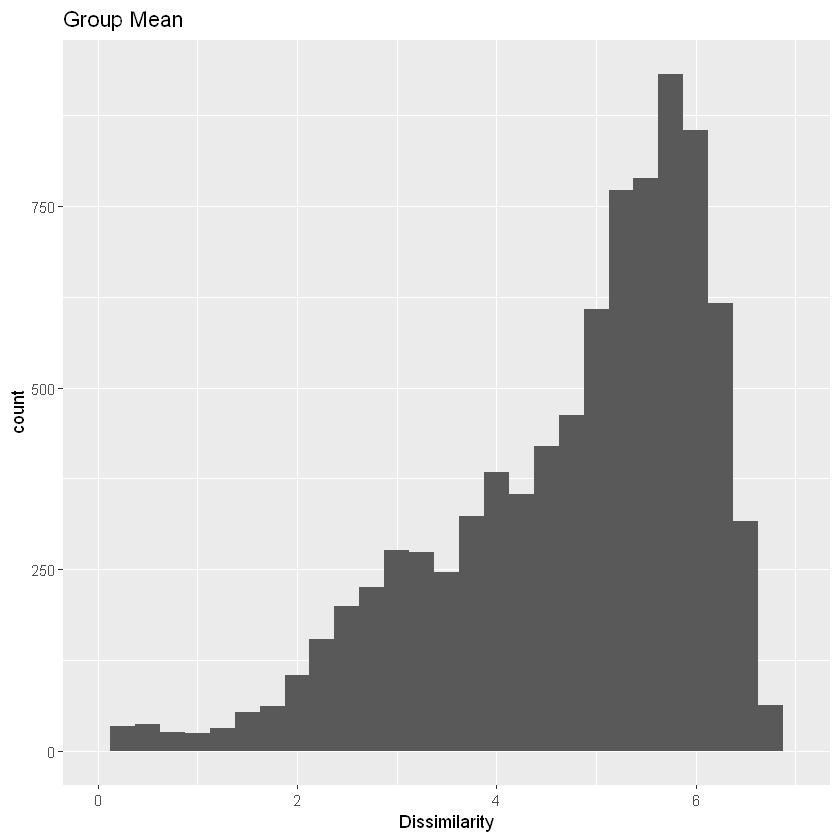

In [380]:
# distribution of dissimilarity values
dissim.distr <- ggplot(group.mean.df, aes(x=mean)) + geom_histogram(binwidth=0.25) +
                xlim(0,7) + xlab('Dissimilarity') + ggtitle('Group Mean')
dissim.distr

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 111 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."


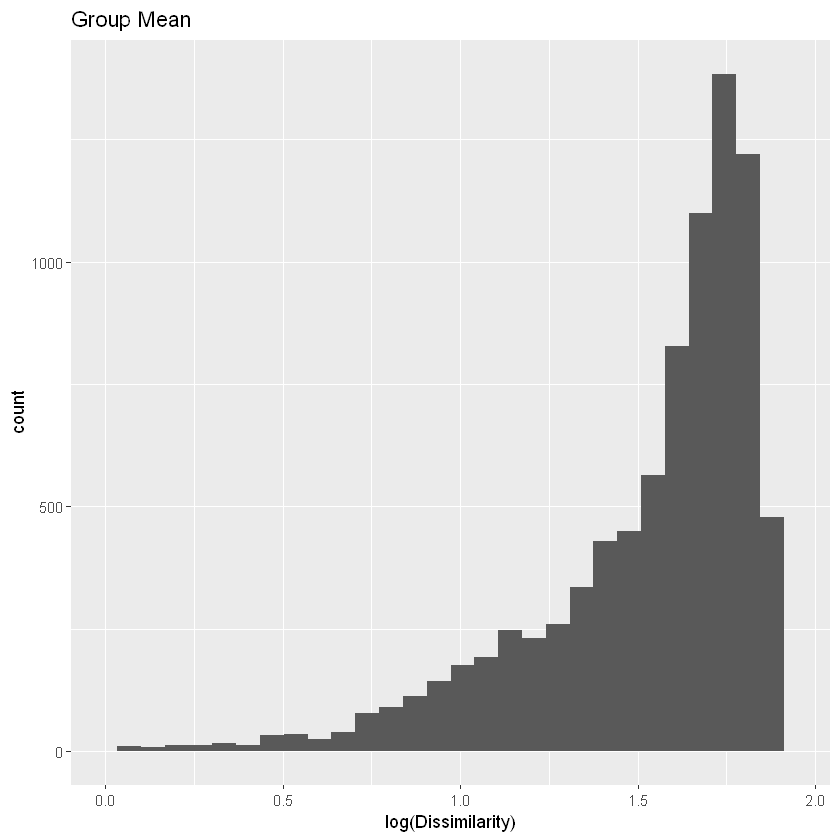

In [391]:
log.dissim.distr <- ggplot(group.mean.df, aes(x=log(mean))) + geom_histogram() +
                xlim(0,log(7)) + xlab('log(Dissimilarity)') + ggtitle('Group Mean')
log.dissim.distr

### Additional visualisations

Data distribution of a beta distribution - can I visualise the data using MDS after putting the data through a beta distribution link function?

In [394]:
# set up the MDS matrix
data.dist <- dist(mean.mat, diag=TRUE)

In [398]:
mean.mds <- cmdscale(data.dist, k = 3)

# Create x, y, z refs
data.x <- mean.mds[,1]
data.y <- mean.mds[,2]
data.z <- mean.mds[,3]